In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model, Input
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, InputLayer, ZeroPadding2D, GlobalAvgPool2D, Reshape, Softmax
from keras.datasets import cifar10
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt
from skimage.transform import resize


%matplotlib inline

/Users/Beebs/miniconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data: (32,32,3) Images

In [2]:
#  This tutorial attempts to achieve transfer learning on incompatible image sizes with MobileNet.
#  Why do this, when we could just load a different (compatible) data set, or use a different model?
#  Because!  Well, this is a tutorial, and it illustrates the practical issues of transfer learning.


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#  Check shapes.

[7]


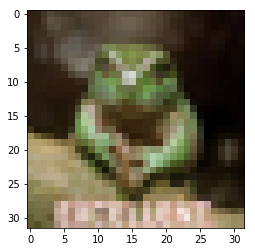

In [3]:
#Convince yourself that the labels are consistent with the data.  
#See https://www.cs.toronto.edu/~kriz/cifar.html
print(y_train[7])   
plt.imshow(x_train[4999])

## Resize

In [ ]:
%%time

#  Resize.
#  One option to deal with the fact that MobileNet does not like (32,32,3) shape is to resize the images.
#  NOTE:  On my machine, resizing the entire training data set would take, according to my precise calculations, a very long time.
#  I will only be resizing and training on 5,000 (about 50 minutes for me), creating a 2 gig file.
#  You will have to do this on your own, but it is possible to store large files on github: https://git-lfs.github.com

#  Base case.


resized_train_data = []
resized_train_data = np.reshape(np.append(resized_train_data, resize(x_train[0],(128,128,3))),(128,128,3))

#  Change range to 50000 if you want to do the entire set.    
#  NOTE:  It may take a while.  If you know a better way, please share. :)

for row in range(5000):
    if row > 0:
        resized = resize(x_train[row],(128,128,3))
        resized_train_data = np.reshape(np.append(resized_train_data, resized),((row+1),128,128,3))
          

In [ ]:
plt.imshow(resized_train_data[4999])

### Save

In [ ]:
#resized_train_data

## Clean Data:  Binary Reps. of Categories, Unrolling, Scaling

In [4]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256

#Reshape for convolutions
x_train_reshape = x_train.reshape(-1,32,32,3) / 256
print(x_train_reshape.shape)
#print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)
print(y_train_encoded.shape)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 32, 32, 3)
(50000, 10)


In [5]:
#load_resized = np.load('resized_5k_images.npy')

#  Or, alternately if you saved as .npz
with np.load('/Users/Beebs/Desktop/resized_5k_images.npz') as data:
    load_resized = data['arr_0']

In [6]:
load_resized.shape

(5000, 128, 128, 3)

In [ ]:
onek_labels = y_test_encoded[:1000]
onek_resized = load_resized[:1000,:,:]
onek_resized.shape

In [7]:
fivek_labels = y_test_encoded[:5000]
#fivek_resized = load_resized[:5000,:,:]
fivek_labels.shape

(5000, 10)

## Create Unbiased Conv. NN

In [ ]:
fresh = MobileNet(input_shape=(128,128,3),include_top =True, weights=None,classes=10)
fresh.summary()
len(fresh.layers)
fresh.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



In [ ]:
%%time
fresh.fit(onek_resized,onek_labels,epochs = 5,batch_size=4)

## Add Adapters for Data Dimensions

In [ ]:
#Documentation for MobileNet says smaller shapes allowed, but throws error.  https://keras.io/applications/#mobilenet
#Thus, we have to adapt a new model to take the dimensions of our data.

rand_init_model = Sequential()

rand_init_model.add(InputLayer(input_shape=(128,128,3),name='INPUT'))
#rand_init_model.add(ZeroPadding2D())
#rand_init_model.add(Conv2D(filters=1,kernel_size=(1,1),input_shape=(32,32,3),name='CONVA'))
#rand_init_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
rand_init_model.layers.extend(fresh.layers[1:])

#print(rand_init_model.layers[-1].output_shape)
#rand_init_model.add(ZeroPadding2D())
#print(rand_init_model.layers[-1].output_shape)
#rand_init_model.add(Reshape((10)))
#print(rand_init_model.layers[-1].output_shape)
rand_init_model.add(GlobalAvgPool2D(data_format='channels_first'))
#print(rand_init_model.layers[-1].output_shape)
rand_init_model.add(Reshape((1,1,-1)))

#print(rand_init_model.layers[-1].output_shape)
#rand_init_model.add(Dropout(rate=0.001))
#print(rand_init_model.layers[-1].output_shape)
rand_init_model.add(Conv2D(filters=10,kernel_size=(5,5),name='CONVZ'))
print(rand_init_model.layers[-1].output_shape)
rand_init_model.add(Softmax())
print(rand_init_model.layers[-1].output_shape)
#rand_init_model.add(Dense(10,activation = 'softmax', name='cifar10_class_adapter'))
rand_init_model.add(Reshape((-1,)))
print(rand_init_model.layers[-1].output_shape)

rand_init_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
rand_init_model.summary()

## Fit and Plot

In [ ]:
%%time
history_fresh = rand_init_model.fit(x_train,y_train_encoded, epochs=25)

In [ ]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

## Create Biased Conv. NN

In [ ]:
# Pretrained weights only exist for certain shapes, which is why we get an error with smaller image sizes.
# We will use the weights anyways for this tutorial, but try loading other data sets with compatible image sizes.
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
for layer in trained_model.layers:
    layer.trainable = False

#Check number of trainable parameters after freezing layers.
trained_model.summary()
#trained_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Create new model to add the trained model into.  Again with adapters.
transfer_model = Sequential()
#transfer_model.add(Dense(64,input_dim=(32*32*3), activation = 'sigmoid',name='cifar10_in_adapter'))
    
    
#Extend list of layers to include layers of trained_model.
#Check summary on model to see the layer structures.
#Remember, include_top = False has already chopped off the classification layers.

transfer_model.add(InputLayer(input_shape=(128,128,3),name='INPUT'))

transfer_model.layers.extend(trained_model.layers[1:97])
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Reshape((1,1,-1)))
#transfer_model.add(Reshape((-1,)))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Conv2D(filters=10,kernel_size=(3,3),name='CONVZ'))
transfer_model.add(GlobalAvgPool2D(data_format='channels_first'))
transfer_model.add(Dropout(rate=0.001))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Flatten())
print(transfer_model.layers[-1].output_shape)
transfer_model.add(Dense(10, activation = 'softmax', name = 'cifar10_class_adapter'))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(GlobalAvgPool2D(data_format='channels_first'))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Reshape((1,1,-1)))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Dropout(rate=0.001))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Conv2D(filters=10,kernel_size=(3,3),name='CONVZ'))
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Softmax())
print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Reshape((-1,)))

print(transfer_model.layers[-1].output_shape)
#transfer_model.add(Softmax())

#transfer_model.add(Flatten())
print(transfer_model.layers[-1].output_shape)

#Experiment: freeze all trainable params.  What do you expect to happen to the acc?  Check summary.
#transfer_model.trainable = False  
transfer_model.summary()
transfer_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [ ]:
%%time
transfer_model.fit(fivek_resized,fivek_labels,epochs=10,batch_size=4)

In [ ]:
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')
transfer_model = Sequential()
transfer_model.layers.extend(trained_model.layers[1:])

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
#for layer in trained_model.layers:
#    layer.trainable = False



In [9]:
#  Since we are doing a more complex model, we use the functional API Model() class from keras.
#  We manually describe the inputs and outputs.

sess = tf.InteractiveSession()
#trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
#for layer in trained_model.layers:
#    layer.trainable = False

    

#tf.reset_default_graph()




with tf.variable_scope(name_or_scope="transferring",reuse=None):
    
    inputs = Input(shape = (128,128,3)) 

        #transfer_model = Sequential()
        #transfer_model = Sequential([Input(shape = (128,128,3))]) 
        #transfer_model.layers.extend(trained_model.layers[1:])



    trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet', input_tensor = inputs)

    #Freeze: keep some pre-trained weights as they are.
    #Try freezing other layers.
    for layer in trained_model.layers:
        layer.trainable = False
    
    #  We can just plug the biased model into a layer.
    #x = trained_model(inputs)

    #  Then, if we want we can copy as close as possible the 
    #  structure of the layers removed by include_top=False.

    x = GlobalAvgPool2D(data_format='channels_last')(trained_model.output)
    x = Reshape((1,1,-1))(x)
    #x = Dropout(rate=0.001)(x)
    x = Conv2D(filters=10,kernel_size=(1,1))(x)
    x = Activation(activation = 'softmax')(x)
    predictions = Reshape((-1,))(x)


    transferable_model = Model(inputs = inputs,outputs = predictions)
    transferable_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
    transferable_model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [11]:
transferable_model.fit(load_resized,fivek_labels,epochs=5,batch_size=4)

Epoch 1/5
2124/5000 [===========>..................] - ETA: 1:31 - loss: 2.7294 - acc: 0.1210

KeyboardInterrupt: 

## Fit

In [ ]:
%%time
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=15)

In [ ]:
plt.plot(history_transfer.history['loss'])

## Prediction and Scoring

In [ ]:
# Supress scientific notation for easier comparison.
np.set_printoptions(suppress=True)

#Predict and look at an example to compare between biased and unbiased.
unbiased_prediction = rand_init_model.predict_proba(x_test_unrolled)
sum(unbiased_prediction[76])

In [ ]:
biased_prediction = transfer_model.predict_proba(x_test_unrolled)
biased_prediction[76]

In [ ]:
#True label:
y_test_encoded[76]

In [ ]:
#Unbiased
#Brier score, lower is better: smaller distance between prediction and true label.  
#Try looking at prediction scores before and after training.
unbiased_diff = y_test_encoded - unbiased_prediction
score_u = np.sum((1/10000)*(np.power(unbiased_diff,2)),axis=1)

#Overall score for 10000 test examples.
sum(score_u)

In [ ]:
#Biased
biased_diff = y_test_encoded - biased_prediction  
score_b = np.sum((1/10000)*(np.power(biased_diff,2)),axis=1)

sum(score_b)

In [ ]:
a = fresh.layers[2]
b = a.get_weights()
b[0].shape

In [ ]:
    VarSc
    hk